In [1]:
#%%
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
plt.style.use('seaborn-darkgrid')

#%%
# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

#%%
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2]) #转one hot 0--->(1,0,0), 1--->(0,1,0), 2--->(0,0,1)
n_classes = y.shape[1]

#%%
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
# concatenation along the second axis.
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]  #np.c_ : 将两个矩阵左右拼接,这里相当于给原来的每个样本加了800个特征


In [12]:
t1 = np.array([[1,2,3],[4,5,6]])
t2 = np.array([[7,8,9],[10,11,12]])
print(np.c_[t1,t2])
print(np.r_[t1,t2])
               



[[ 1  2  3  7  8  9]
 [ 4  5  6 10 11 12]]
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


In [3]:
#%%
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print(y_score)

[[-0.76301132 -0.36482547  0.12386354]
 [-0.20224493 -0.63144366 -0.16612302]
 [ 0.11801481 -0.80263073 -0.32055874]
 [-0.90780855 -0.12395478  0.02199789]
 [-0.01116192 -0.27913475 -0.71889214]
 [-0.6048727  -0.34730509 -0.05859016]
 [ 0.02283491 -0.24506467 -0.79111998]
 [-0.61076876  0.18264917 -0.57199363]
 [-0.37572754 -0.24059516 -0.38933694]
 [-0.47017411 -0.25745136 -0.27510839]
 [-0.42224234 -0.30270719 -0.27995197]
 [-0.3355867  -0.7030665   0.02530178]
 [-0.22723929 -0.64062258 -0.13456902]
 [-0.07856729 -0.46354017 -0.45918364]
 [-0.53383361 -0.2653183  -0.20023832]
 [ 0.12163662 -0.56706353 -0.56980985]
 [-0.71356947 -0.04226738 -0.24297128]
 [-0.55111511 -0.13784913 -0.31370595]
 [ 0.37991331 -0.99673302 -0.39090964]
 [-0.11107635 -0.91349462  0.03129167]
 [-0.70713712 -0.06436533 -0.21423788]
 [-0.02392675 -0.45906496 -0.51922684]
 [-0.25045747 -0.80086123  0.04121338]
 [ 0.12675547 -0.70985659 -0.41072849]
 [-0.68210402 -0.20735021 -0.12051204]
 [-0.08001795 -0.36698232

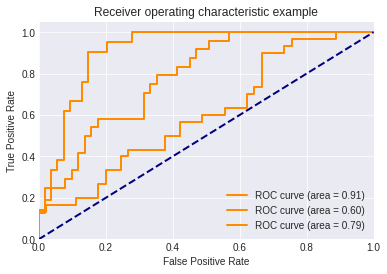

/home/wmf/Downloads/anaconda3/envs/TF2.1/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


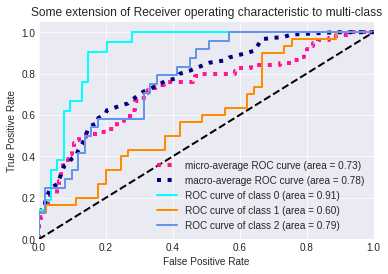

One-vs-One ROC AUC scores:
0.698586 (macro),
0.665839 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.698586 (macro),
0.665839 (weighted by prevalence)


In [4]:
#%%
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


#%%

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# %%

# Compute micro-average ROC curve and ROC area
# Average over all samples
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Average over classes
# First aggregate all false positive rates (x-axis)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#%%
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# %%
# Multi-class
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

# %%